# Setting up a more general LMC with SVI

Focus in this notebook will be on setting up a much more general, and in-line with the wider literature, version of the LMC in `gpytorch`.

Remember that the in it's most general form, the LMC is a linear combination of many latent (independent) GPs that are grouped according to their covariance functions. Assuming we have $Q$ groups, with $R_q$ latent functions in each group, for a total of $R=\sum_{q=1}^Q R_q$ latent functions,  the $k-th$ output can be written as
$$
f_k(x) = \sum_{q=1}^Q\sum_{r=1}^{R_q} a_{kr}^{(q)} u_{r}^{(q)}(x),
$$
where all $u_{r}^{(q)} \sim \mathcal{GP}(0,\kappa_q(\cdot,\cdot))$. Note the indexing on the covariance function meaning that all latent GPs corresponding to the $q$-th group have the same covariance function. 

Writing this on matrix-form, where we assume $n$ observations over $m$ outputs, we can write:




\begin{align}
\begin{bmatrix}
f_1(x) \\
f_2(x) \\
\vdots \\
f_m(x) 
\end{bmatrix} &=
\begin{bmatrix}
a_{11}^{(1)} & a_{12}^{(1)} & \cdots & a_{1R_1}^{(1)} & a_{11}^{(2)} & a_{12}^{(2)} & \cdots & a_{1R_2}^{(2)} & \cdots & a_{11}^{(Q)} & a_{12}^{(Q)} & \cdots & a_{1R_Q}^{(Q)} \\
a_{21}^{(1)} & a_{22}^{(1)} & \cdots & a_{2R_1}^{(1)} & a_{21}^{(2)} & a_{22}^{(2)} & \cdots & a_{2R_2}^{(2)} & \cdots &  a_{21}^{(Q)} & a_{22}^{(Q)} & \cdots & a_{2R_Q}^{(Q)}  \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \cdots &  \vdots & \vdots & \ddots & \vdots \\
a_{m1}^{(1)} & a_{m2}^{(1)} & \cdots & a_{mR_1}^{(1)} & a_{m1}^{(2)} & a_{m2}^{(2)} & \cdots & a_{mR_1}^{(2)} & \cdots & a_{m1}^{(Q)} & a_{m2}^{(Q)} & \cdots & a_{mR_Q}^{(Q)} \\
\end{bmatrix}
\begin{bmatrix}
u_1^{(1)}(x) \\
u_2^{(1)}(x) \\
\vdots \\
u_{R_1}^{(1)}(x) \\
u_1^{(2)}(x) \\
u_2^{(2)}(x) \\
\vdots \\
u_{R_2}^{(2)}(x) \\
\vdots \\
u_1^{(Q)}(x) \\
u_2^{(Q)}(x) \\
\vdots \\
u_{R_Q}^{(Q)}(x) \\
\end{bmatrix}
\end{align}
or more concisely as:

\begin{align}
\mathbf{f}(x) = A \mathbf{u}(x),
\end{align}

where the columns of matrix $A$ is grouped into $Q$ groups, $A=[A_1 \ \cdots \ A_Q]$, and each $A_q$ is an $m\times R_q$ matrix with entries $[A_q]_{ij} = a_{ij}^{(q)}$. The parameters $a_{ij}^{q}$ are referred to as the LMC coefficients, usually to be learned during training. 

This structure means that the covariance between two observations from two outputs takes a special form

\begin{align}
\text{Cov}[f_i(x),f_j(x')] &= \text{Cov}\left[\sum_{q=1}^Q\sum_{r=1}^{R_q} a_{ir}^{(q)} u_{r}^{(q)}(x),\sum_{q=1}^Q\sum_{r=1}^{R_q} a_{jr}^{(q)} u_{r}^{(q)}(x)\right] \\
&= \sum_{q=1}^Q\sum_{r=1}^{R_q} a_{ir}^{(q)}a_{jr}^{(q)}\text{Cov}[u_r^{(q)}(x),u_r^{(q)}(x')] \\
&= \sum_{q=1}^Q\kappa_q(x,x')\sum_{r=1}^{R_q} a_{ir}^{(q)}a_{jr}^{(q)}.
\end{align}

Where $\sum_{r=1}^{R_q} a_{ir}^{(q)}a_{jr}^{(q)}$ is the dot-product between the $i$-th and $j$-th row of the matrix $A_q$. 

Taking the covariance over the entire vector $\mathbf{f}(x)$ of all outputs we obtain:

\begin{align}
\text{Cov}[\mathbf{f}(x),\mathbf{f}(x')] &= \sum_{q=1}^Q A_qA_q^T\kappa_q(x,x') \\
&=  \sum_{q=1}^Q B_q\kappa_q(x,x'),
\end{align}
where the matrix $B_q=A_qA_q^T$ is called the *coregionalization* matrix. If furthermore each output $f_j(x)$ has been observed on the same set of inputs $X=\{x_1,\ldots,x_n\}$, then the covariance can be written as 

\begin{align}
\text{Cov}[\mathbf{f}(X),\mathbf{f}(X')] &= \sum_{q=1}^Q B_q \otimes K^{(q)}_{ff},
\end{align}
where $K^{(q)}_{ff}=\kappa_q(X,X)$.


Now, the *intrinsic model of coregionalization* (ICM) is the special case of this model where we only have one group of latents, $Q=1$. We'll still have $R$ latent variables, but these will all belong to the same group, and hence share the covariance function, i.e. RBF with the same length-scale.

## Current LMC implementation in GPyTorch
The way the LMC is currently set up within GPyTorch is quite simplistic. 

The `LMCVariationalStrategy` has a parameter `num_latents` which one would think controls the number $R=\sum_{q=1}^Q R_q$, but each latent GP will be given its own covariance function, so setting this parameter is equal to controlling $Q$ and simultaneously setting $R_q = 1 \  \forall  \ q=1,\ldots,Q$. 

When setting up the model, one typically does something like 

```
self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )
```
for setting up the covariance function. Calling `batch_shape=num_latents` sets it up such that each latent function gets it's own covariance function. A way around this, which will yield an ICM is to remove the batch_shape in the kernel function. That is, when setting up a model, simply do

```
self.covar_module = gpytorch.kernels.RBFKernel()
```
which will ensure the same kernel with the same length scale across all latent functions.

Now, what I need is the ability to set $Q$ and $R_q$ seperately. I don't necessarily need a separate $R_q$ for all $Q$ and I'd be happy with $R_1=R_2=\cdots=R_Q\equiv R$. 



To do this, I need to understand specifically what happens internally when I call something like 

```
 self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )
```
and how the batch_shape is used in later calculations.

Well, setting up a kernel with this yields `num_latent` different lengthscales, one for each latent, and evaluating `covar_module(x)` produces `num_latent` covariance matrices. See below:

In [ ]:
import torch
import gpytorch
num_latents = 3
Q  = 2
covar_module = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([Q,num_latents]))
print(covar_module.lengthscale) # So these will have a separate lengthscale per batch.
x = torch.linspace(0,1,10)
K = covar_module(x)
print(K.shape)

Okay, so how do we move on from here? 

Instead of trying to force a grouping structure on the batch_shape, it might be easier to directly modify the `LMCVariationalStrategy`?

At the moment, the model is set up as:


And then inside the `LMCVariationalStrategy`

The covariates are evaluated at each latent_function and returns a *batch* multivariate normal (each latent is independent of course.

`latent_dist = self.base_variational_strategy(x, prior=prior, **kwargs)`

These are then combined with the LMC coefficients to produce a normal distribution over the outputs.

How does base_variational_strategy obtain the length-scale?

Appears from something like `self.model.covariance`, so a bit untouchable.

Well, I know what happens if batch_shape of the kernel is null, everything just gets copied up and reused. Will a similar thing happen if one of the dims is the correct shape? I need to set up a model and see.


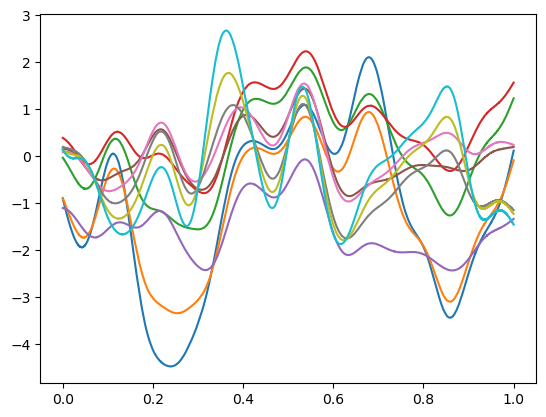

In [1]:
# Code starts as before, with some imports and generating data
# Some imports
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
r = 4 # Number of latents
n = 5000 # Number of observations per output
# Easiest way to sample from a GP using gpytorch?
x = torch.linspace(0,1,n)
u1 = torch.zeros(x.size(dim=0),r)
u2 = torch.zeros(x.size(dim=0),r)


mean1 = gpytorch.means.ZeroMean()
mean2 = gpytorch.means.ZeroMean()
kernel1 = gpytorch.kernels.RBFKernel()
kernel1.lengthscale = 1.5
kernel2 = gpytorch.kernels.RBFKernel()
kernel2.lengthscale = 0.05
m1 = mean1(x)
m2 = mean2(x)
K1 = kernel1(x)
K2 = kernel2(x)
for i in range(r):
    GP1 = gpytorch.distributions.MultivariateNormal(m1,K1)
    GP2 = gpytorch.distributions.MultivariateNormal(m2,K2)
    u1[:,i] = GP1.rsample().detach()
    u2[:,i] = GP2.rsample().detach()
    
    
# Now creating outputs as linear combinations of these latent functions
# but now the lmc-parameters A is coming from another kernel over some covariates

m = 10 # num_outputs
covar_outputs1 = torch.cat([1+0.5*torch.randn(int(m/2.)),-1+0.5*torch.randn(int(m/2.))])
covar_outputs2 = torch.linspace(-1,1,m)
# These are just some really dumb covariates which will give some clustering structure
covar_kernel1 = gpytorch.kernels.RBFKernel()
covar_kernel1.lengthscale = 0.4
covar_kernel1 = covar_kernel1(covar_outputs1)
covar_kernel2 = gpytorch.kernels.PolynomialKernel(offset=0,power=2)
covar_kernel2 = covar_kernel2(covar_outputs2)
evals1, evecs1 = covar_kernel1.symeig(eigenvectors=True)
evecs1 = evecs1[:, -r:]
evals1 = linear_operator.operators.DiagLinearOperator(evals1[-r:])
A1 = evecs1.matmul(evals1.sqrt()).evaluate().detach()

evals2, evecs2 = covar_kernel2.symeig(eigenvectors=True)
evecs2 = evecs2[:, -r:]
evals2 = linear_operator.operators.DiagLinearOperator(evals2[-r:])
A2 = evecs2.matmul(evals2.sqrt()).evaluate().detach()

f = A1.matmul(u1.t()).t() + A2.matmul(u2.t()).t()
for i in range(m):
    plt.plot(x,f[:,i])
    
# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())

# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader

# Get everything into long format
y_long = y.t().reshape(-1)
x_long = x.repeat(m)
task_indices = torch.arange(0,m).unsqueeze(1).repeat(1,n).reshape(-1).long()

# For last task, will remove some central observations 
#y_long[-5000:] = float('nan')
#x_long = x_long[~y_long.isnan()]
#task_indices = task_indices[~y_long.isnan()]
#y_long = y_long[~y_long.isnan()]

train_dataset = TensorDataset(x_long, y_long,task_indices)
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

# We also make a version for test here
test_x = torch.linspace(0, 1, 51).repeat(m)
test_indices = torch.arange(0,m).unsqueeze(1).repeat(1,51).reshape(-1).long()

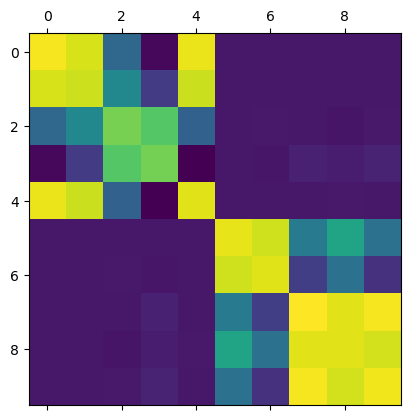

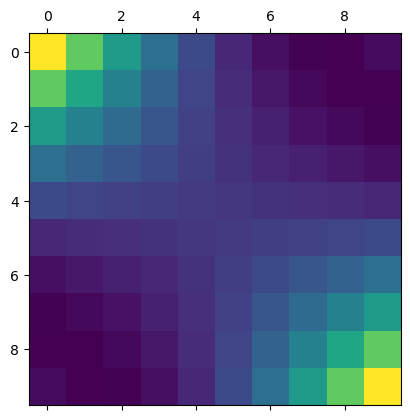

In [2]:
plt.matshow(A1.matmul(A1.t()))
plt.matshow(A2.matmul(A2.t()))

In [3]:
from synpred.variational.modified_lmc_variational_strategy import ModifiedLMCVariationalStrategy

class ModifiedLMC1(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        print("Init is run!")
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,100,1)
        # Same set of inducing points for each latent function
        #inducing_points = torch.linspace(0,1,30).unsqueeze(-1).repeat(r,1,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        #variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        #    inducing_points.size(-2), batch_shape=torch.Size([r])
        #)
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.RBFKernel()
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = ModifiedLMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super(ModifiedLMC1,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
    

#model = ModifiedLMC(covar_outputs)
#likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [4]:
from synpred.variational.modified_lmc_variational_strategy import ModifiedLMCVariationalStrategy

class ModifiedLMC2(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        print("Init is run!")
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,100,1)
        # Same set of inducing points for each latent function
        #inducing_points = torch.linspace(0,1,30).unsqueeze(-1).repeat(r,1,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        #variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        #    inducing_points.size(-2), batch_shape=torch.Size([r])
        #)
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.PolynomialKernel(offset=0,power=2)
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = ModifiedLMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super(ModifiedLMC2,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Actually, I think the full LMC would just be a sum over $Q$ independent ICMs. So I could set up the model like before, for the ICM, then make Q independent instances of it. Pass that through the likelihood, and be done.

I can just make a simple wrapper for this extending the base `GP` method. With a simple init setting up e.g. 2 ICM models independently, then in the forward I just add together means and covariances.

This works below, I set up a new variational strategy called `SumVariationalStrategy` that takes as input 2 ICM models and combines them. Implemented are methods for calling the prior, the variational distribution and the KL-divergence. I do some manual work to concatenate distributions, and I should add some checking to see that the distribution have the correct batch shapes, i.e. should have the same number of inducing points for each latent in both models. This might be overkill for the application, but we can look at that later.

In the `__call__` I simply call the two latent ICM models on the inputs and sum them.

The final thing I'm going to do is allow the `SumVariationalStrategy` to take a list of models as input.

In [6]:
# I need a new variational strategy
from gpytorch.module import Module
from abc import ABC
from gpytorch.distributions import MultivariateNormal
from torch import Tensor
from typing import List
from torch.nn import ModuleList


def _concat_distributions(distr: List[gpytorch.distributions.MultivariateNormal], jitter_val) -> MultivariateNormal:
    mean = torch.cat([dist.mean for dist in distr],0)
    covar = torch.cat([dist.lazy_covariance_matrix.add_jitter(jitter_val).evaluate() for dist in distr],0)
    return MultivariateNormal(mean,covar)
    

class SumVariationalStrategy(gpytorch.variational._VariationalStrategy):
    #def __init__(self, model1: gpytorch.models.ApproximateGP, model2: gpytorch.models.ApproximateGP):
    def __init__(self, models: ModuleList):
        #print("here!")
        Module.__init__(self)
        #print("or here!")
        self.models = models
        print((self.models)[0])
        self.jitter_val = gpytorch.settings.variational_cholesky_jitter.value(
                (self.models[0]).variational_strategy.base_variational_strategy.inducing_points.dtype
            )
        
    @property
    def prior_distribution(self) -> MultivariateNormal:
        #A = self.model1.variational_strategy.prior_distribution
        #B = self.model2.variational_strategy.prior_distribution
        return _concat_distributions([model.variational_strategy.prior_distribution for model in self.models],self.jitter_val)
            
    @property
    def variational_params_initialized(self) -> bool:
        return self.models[0].variational_strategy.variational_params_initialized
    
    @property
    def variational_distribution(self) -> MultivariateNormal:
        #A = self.model1.variational_strategy.variational_distribution
        #B = self.model2.variational_strategy.variational_distribution
        return _concat_distributions([model.variational_strategy.variational_distribution for model in self.models],self.jitter_val)
        
    
    def kl_divergence(self) -> Tensor:
        return super().kl_divergence().sum(-1)
        
    
    def __call__(self, x: torch.Tensor, prior: bool = False, **kwargs) -> gpytorch.distributions.MultivariateNormal:
        #print("call?")
        function_dist = sum([model(x,prior=prior,**kwargs) for model in self.models])
        #latent_dist1 = self.model1(x,prior=prior, **kwargs)
        #latent_dist2 = self.model2(x,prior=prior, **kwargs)
        #mean = latent_dist1.mean + latent_dist2.mean
        #covar = latent_dist1.lazy_covariance_matrix + latent_dist2.lazy_covariance_matrix
        #function_dist = latent_dist1 + latent_dist2
        
        return function_dist

So this does end up working. I just need to make it a bit more general summing over Q functions.




Now, when setting up the model I initialize two ICM models that I've previously defined as the class `ModifiedLMC` (as it was a modification of the LMC model with non-batch kernels). And I init the variational strategy. The forward is skipped, because everything is taken care of in the calls.

In [7]:
class LMC(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        model1 = ModifiedLMC1(covar_outputs1)
        model2 = ModifiedLMC2(covar_outputs2)
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = SumVariationalStrategy(ModuleList([model1,model2]))
        
        super(LMC,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        #self.mean_module1 = gpytorch.means.ZeroMean()
        #self.covar_module1 = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        print("is soemthing happening here?")
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        #mean_x = self.mean_module(x)
        #covar_x = self.covar_module(x)
        #return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        raise NotImplementedError


    
    

model = LMC(covar_outputs1)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Init is run!
Init is run!
ModifiedLMC1(
  (variational_strategy): ModifiedLMCVariationalStrategy(
    (base_variational_strategy): VariationalStrategy(
      (_variational_distribution): NaturalVariationalDistribution()
    )
    (output_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
)


Training is just like before

In [ ]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
num_epochs = 20 # Number of complete passes through the data


model.train()
likelihood.train()

#optimizer = torch.optim.Adam([
#    {'params': model.parameters()},
#    {'params': likelihood.parameters()},
#], lr=0.001)


variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y_long.size(0), lr=0.01)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Uncomment to keep the LMC coefficients fixed at true values
#model.variational_strategy.lmc_coefficients = torch.nn.Parameter(A.t())
#optimizer = torch.optim.Adam([
#    {'params': list(set(model.parameters()) - {model.variational_strategy.lmc_coefficients, })},
#    {'params': likelihood.parameters()},
#], lr=0.01)


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
#mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_long.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch, task_batch in minibatch_iter:
        #optimizer.zero_grad()
        #output = model(x_batch,task_indices=task_batch)
        #loss = -mll(output, y_batch)
        #minibatch_iter.set_postfix(loss=loss.item())
        #loss.sum().backward()
        #optimizer.step()
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch,task_indices=task_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()
        
    #optimizer.zero_grad()
    #output = model(x)
    #loss = -mll(output, y)
    #epochs_iter.set_postfix(loss=loss.item())
    #loss.backward()
    #optimizer.step()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/167 [00:00<?, ?it/s]

In [17]:
#newoutput = torch.tensor([0.9971,0])
newoutput = torch.linspace(-1,1,10)

test_x = torch.linspace(0, 1, 151).repeat(newoutput.size(-1))
test_indices = torch.arange(0,newoutput.size(-1)).unsqueeze(1).repeat(1,151).reshape(-1).long()

In [18]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #predictions = likelihood(model(test_x,task_indices=test_indices,task_covars=newoutput))
    predictions = likelihood(model(test_x,task_indices=test_indices))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

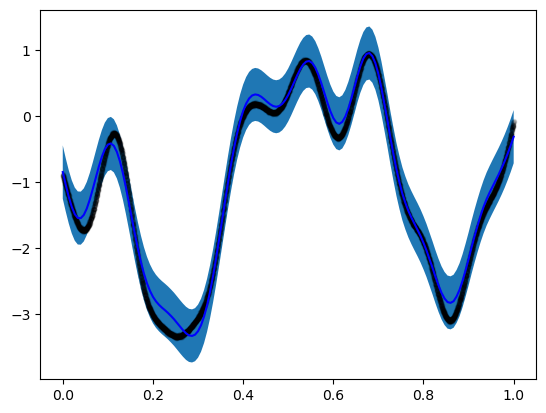

In [27]:
task = 1
plt.plot(x,y[:,task],'k.',alpha=0.1)
plt.plot(test_x[task*151:task*151+151],mean[task*151:task*151+151],"b")
plt.fill_between(test_x[task*151:task*151+151], lower[task*151:task*151+151], upper[task*151:task*151+151])

In [22]:
model.variational_strategy.models[0].covar_module.lengthscale

tensor([[0.9214]], grad_fn=<SoftplusBackward0>)

In [23]:
model.variational_strategy.models[1].covar_module.lengthscale

tensor([[0.0772]], grad_fn=<SoftplusBackward0>)

In [24]:
likelihood.noise

tensor([0.0400], grad_fn=<AddBackward0>)

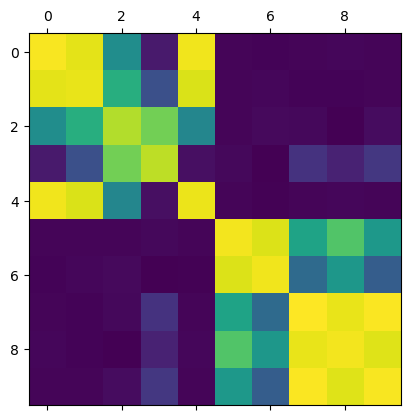

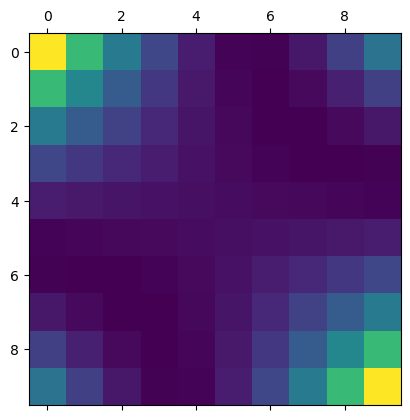

In [26]:
A = model.variational_strategy.models[0].variational_strategy.lmc_coefficients.detach().t()
B = model.variational_strategy.models[1].variational_strategy.lmc_coefficients.detach().t()
plt.matshow(A.matmul(A.t()))
plt.matshow(B.matmul(B.t()))

Allright, so this all now seems to be working. There is some work left setting it up so that it is slightly more customizable, but the main work has been put in. Next, I need to tackle placing inducing points within the framework of permutation invariance.